In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, f1_score, 
                             precision_score, recall_score, accuracy_score, 
                             roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import time
from joblib import dump

In [3]:
#-----------------------------------------
# 1. Load Data
#-----------------------------------------
train_data = pd.read_parquet('./data/train_scaled.parquet')
test_data = pd.read_parquet('./data/test_scaled.parquet')

In [4]:
#-----------------------------------------
# 2. Train/Test Split
#-----------------------------------------
# Separate features and target
X_train = train_data.drop(['class'], axis=1, errors='ignore') 
y_train = train_data['class']

In [5]:
# Separate features and target
X_test = test_data.drop(['class'], axis=1, errors='ignore') 
y_test = test_data['class']

In [6]:
# 3. Handle Class Imbalance (SMOTE)
#-----------------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [7]:
# 4. Define New Models
#-----------------------------------------
models = {
    # "SVC": SVC(probability=True, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Parameter grids for GridSearchCV
param_grids = {
    # "SVC": {
    #     'C': [0.1, 1, 10],
    #     'kernel': ['rbf', 'linear', 'poly'],
    #     'class_weight': [None, 'balanced']
    # },
    "GradientBoosting": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 300],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}


In [8]:
# 5. Hyperparameter Tuning using GridSearchCV
#-----------------------------------------
best_models = {}

for model_name, model in models.items():
    print(f"Training and tuning {model_name} using GridSearchCV...")
    grid = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=3, n_jobs=-1, verbose=3)
    grid.fit(X_train_res, y_train_res)
    best_models[model_name] = grid.best_estimator_
    print(f"Best params for {model_name}: {grid.best_params_}\n")

Training and tuning GradientBoosting using GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.911 total time= 5.4min
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.920 total time=15.6min
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=300;, score=0.923 total time=13.7min
[CV 2/3] END learning_rate=0.2, max_depth=7, n_estimators=100;, score=0.998 total time= 4.1min
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.914 total time= 3.0min
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=300;, score=0.988 total time= 8.0min
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.922 total time= 6.9min
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.999 total time= 2.8min
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=100;, score=1.000 total time= 5.0min
[CV 2/3] END learning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Best params for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 300}



In [11]:
# 6. Evaluate Each Model with Runtime Profiling for Fitting and Prediction
#-----------------------------------------
model_performance = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")

    # Measure training time
    start_fit = time.time()
    model.fit(X_train_res, y_train_res)  # Refit model for fair timing
    end_fit = time.time()
    fit_time = end_fit - start_fit

    # Measure prediction time
    start_predict = time.time()
    y_pred = model.predict(X_test)
    end_predict = time.time()
    predict_time = end_predict - start_predict

    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    model_performance.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Training Time (s)": fit_time,
        "Prediction Time (s)": predict_time
    })

    print(f"{model_name} - Training Time: {fit_time:.4f} s, Prediction Time: {predict_time:.4f} s")
    print("----------------------------------------------------\n")

Evaluating GradientBoosting...
GradientBoosting - Training Time: 381.4492 s, Prediction Time: 0.2264 s
----------------------------------------------------

Evaluating AdaBoost...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Training Time: 90.3311 s, Prediction Time: 0.5560 s
----------------------------------------------------



              Model  Accuracy  Precision    Recall  F1-Score  \
0  GradientBoosting  0.955846   0.997317  0.530125  0.692272   
1          AdaBoost  0.955713   0.993988  0.530481  0.691771   

   Training Time (s)  Prediction Time (s)  
0         381.449173             0.226384  
1          90.331099             0.556006  


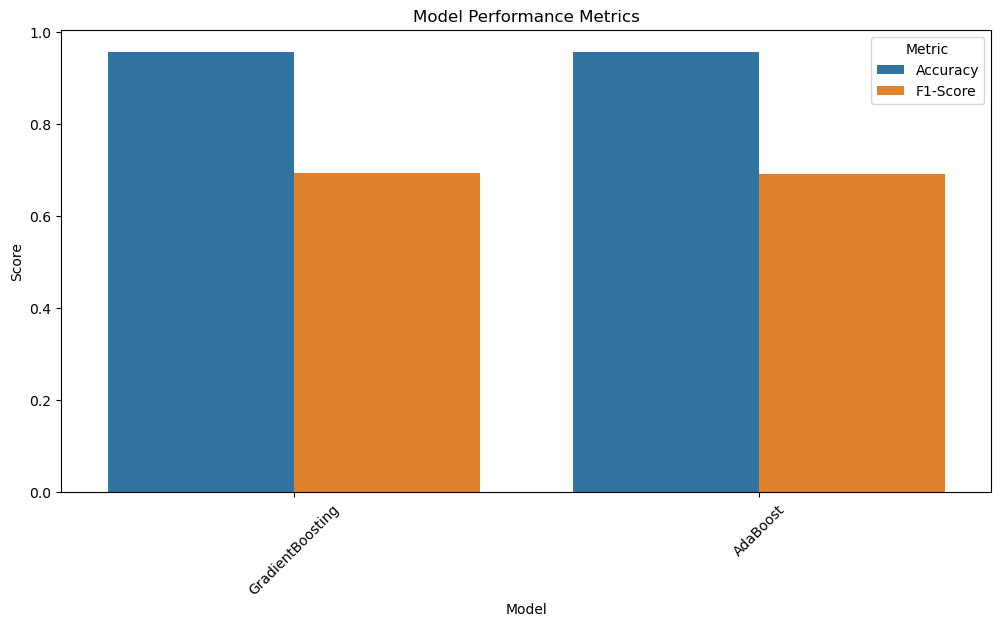

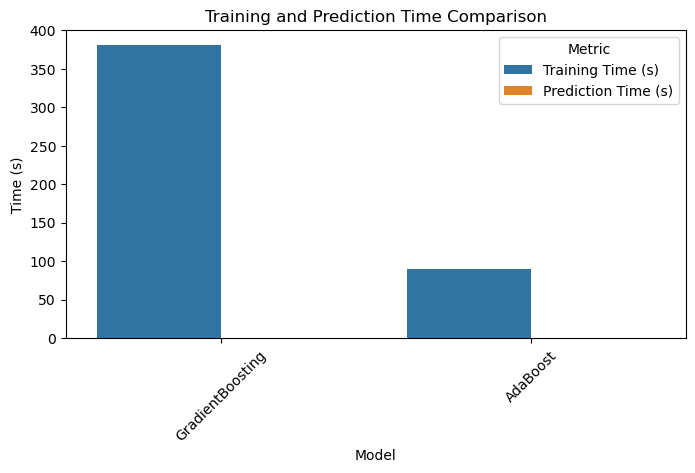

In [12]:
#-----------------------------------------
# 7. Visualize Metrics and Runtime
#-----------------------------------------
# Convert model performance to DataFrame
df_performance = pd.DataFrame(model_performance)

# Sort by F1-Score for ranking
df_performance = df_performance.sort_values(by='F1-Score', ascending=False)

# Display performance
print(df_performance)

# Visualization of metrics
df_performance_melt = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_performance_melt[df_performance_melt['Metric'].isin(['Accuracy', 'F1-Score'])],
            x='Model', y='Score', hue='Metric')
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.show()

# Training and Prediction Time Comparison
time_metrics = df_performance.melt(id_vars='Model', value_vars=['Training Time (s)', 'Prediction Time (s)'], 
                                    var_name='Metric', value_name='Time (s)')

plt.figure(figsize=(8, 4))
sns.barplot(data=time_metrics, x='Model', y='Time (s)', hue='Metric')
plt.title("Training and Prediction Time Comparison")
plt.xticks(rotation=45)
plt.show()

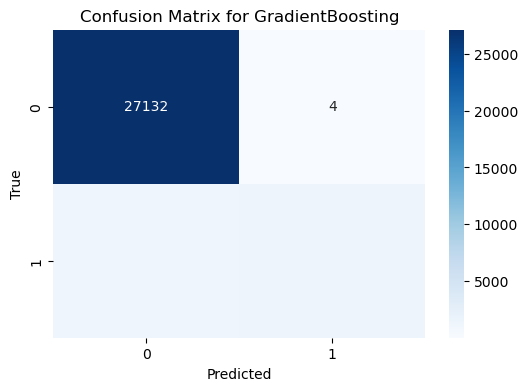

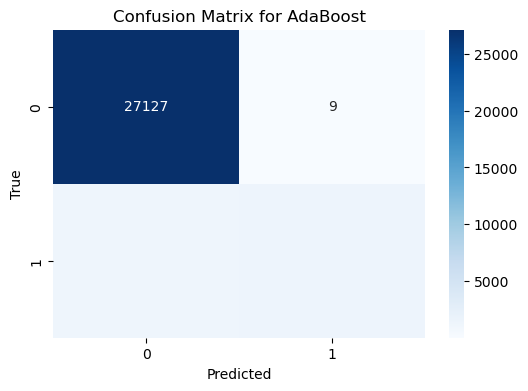

In [13]:
# Confusion matrices for each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

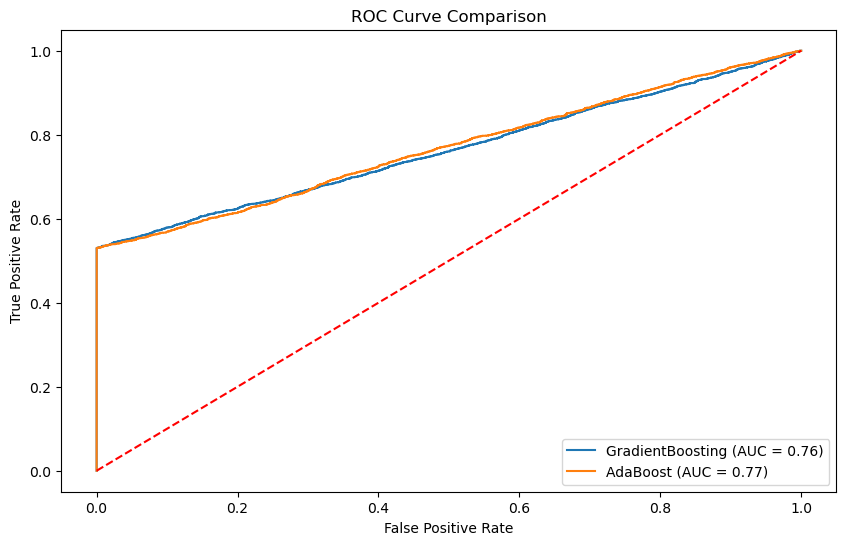

In [14]:
# ROC Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # For models that do not have predict_proba, use decision_function if available
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            # As a fallback, consider predictions as probabilities (not ideal)
            y_proba = model.predict(X_test) 
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

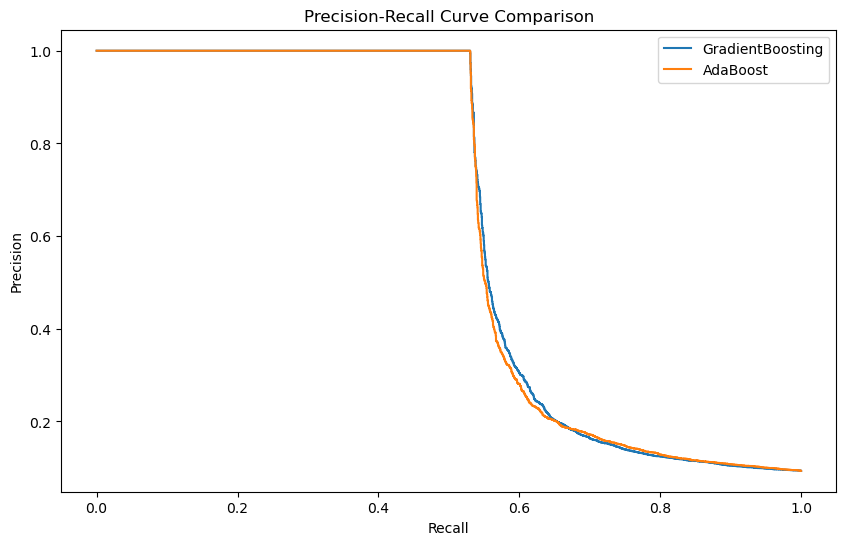

In [15]:
# Precision-Recall Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # fallback as above
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            # fallback to binary predictions (less informative)
            y_proba = model.predict(X_test)
    precision_pts, recall_pts, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_pts, precision_pts, label=model_name)
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

In [16]:
# Determine best model based on F1-score
best_model = max(model_performance, key=lambda x: x['F1-Score'])
print("Best Model based on F1-score is:", best_model["Model"], "with F1-score:", best_model["F1-Score"])
print("Accuracy for best model:", best_model["Accuracy"])

Best Model based on F1-score is: GradientBoosting with F1-score: 0.6922718808193669
Accuracy for best model: 0.9558464981129555
